#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 3 - Deep Reinforcement Learning
# Simone Trevisan 1238612

# DQN

## Envinronment initialization

In [1]:
!pip install gym

In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory
import torchvision.transforms as T
from PIL import Image

In [3]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree     

In [4]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Memories

In [9]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [10]:
class ShortMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"
        for _ in range(capacity):
          self.memory.append(torch.zeros((1,80,80)))

    def push(self, state):
      self.memory.append(state) # Add the last state to the queue

    def get(self):
      if self.memory[2] is None:
        return None
      else:
        ch4_im = torch.stack((
                            torch.squeeze(self.memory[2]),
                            torch.squeeze(self.memory[1]),
                            torch.squeeze(self.memory[0])))
        return ch4_im

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Policy network

### Input sample

torch.Size([1, 80, 80])
tensor([[[-2.2222, -2.2222, -2.2222,  ..., -2.2222, -2.2222, -2.2222],
         [-2.2222, -2.2222, -2.2222,  ..., -2.2222, -2.2222, -2.2222],
         [-2.2222, -2.2222, -2.2222,  ..., -2.2222, -2.2222, -2.2222],
         ...,
         [-2.2222, -2.2222, -2.2222,  ..., -2.2222, -2.2222, -2.2222],
         [-2.2222, -2.2222, -2.2222,  ..., -2.2222, -2.2222, -2.2222],
         [-2.2222, -2.2222, -2.2222,  ..., -2.2222, -2.2222, -2.2222]]])


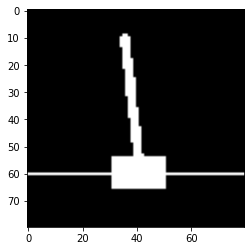

In [11]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)
state = env.reset()
for _ in range(7):
  state = env.step(1)

fig = env.render(mode='rgb_array')
resize = T.Compose([T.ToPILImage(),
                    T.Grayscale(),         
                    T.Resize((160,240), interpolation=Image.CUBIC),
                    T.ToTensor(),
                    T.Normalize(mean=[0.5],
                            std=[0.225]),
                    lambda x: x<1,
                    lambda x: x.float(),
                    T.Normalize(mean=[0.5],
                            std=[0.225])])
fig = resize(fig)
center = state[0][0]*25+120
fig = T.functional.crop(fig,top=60,left=int(center-40),height=80,width=80)
print(fig.shape)
plt.imshow(np.squeeze(fig), 'gray')
env.close()
print(fig)

### Network definition

In [12]:
class DQN(nn.Module):

    def __init__(self, channels, action_space_dim):
        super().__init__()

        self.conv = nn.Sequential(
            # Size = 1x128x192
                nn.Conv2d(in_channels = channels, out_channels = 64, kernel_size = 4, stride = 2, padding=0),
                #nn.LeakyReLU(0.2, inplace=True),
                nn.ReLU(),

                #Size 64x64x96
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=0),
                #nn.BatchNorm2d(128),
                #nn.LeakyReLU(0.2, inplace=True),
                nn.ReLU(),

                #Size 128x32x48
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
                #nn.BatchNorm2d(256),
                #nn.LeakyReLU(0.2, inplace=True),
                nn.ReLU(),

                #Size 128x16x24
                #nn.Conv2d(in_channels=64, out_channels=16, kernel_size=4, stride=4, padding=1),
                #nn.BatchNorm2d(16),
                #nn.LeakyReLU(0.2, inplace=True),

                #Size 16x4x6
                )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=512),
            #nn.Tanh(),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=action_space_dim)
        )

    def forward(self, x):
        return self.linear(self.conv(x))

In [13]:
dqn = DQN(3,2)

from torchsummary import summary
dqn.to(device)
summary(dqn, input_size=(3,80,80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 39, 39]           3,136
              ReLU-2           [-1, 64, 39, 39]               0
            Conv2d-3           [-1, 64, 18, 18]          65,600
              ReLU-4           [-1, 64, 18, 18]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
              ReLU-6           [-1, 64, 16, 16]               0
           Flatten-7                [-1, 16384]               0
            Linear-8                  [-1, 512]       8,389,120
              ReLU-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
             ReLU-11                  [-1, 256]               0
           Linear-12                   [-1, 64]          16,448
             ReLU-13                   [-1, 64]               0
           Linear-14                   

### Exploration Policy

#### Epsilon-greedy policy


In [14]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        state = torch.tensor(state, dtype=torch.float32).to(device)
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.cpu().argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

#### Softmax policy

In [15]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device)
        net_out = net(state)
        #print(net_out)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out.cpu()[0] / temperature, dim=0).numpy()
    #print(softmax_out)            
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    #print(len(all_possible_actions))
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.cpu().numpy()

#### Exploration profile

No handles with labels found to put in legend.


Text(0, 0.5, 'Exploration profile')

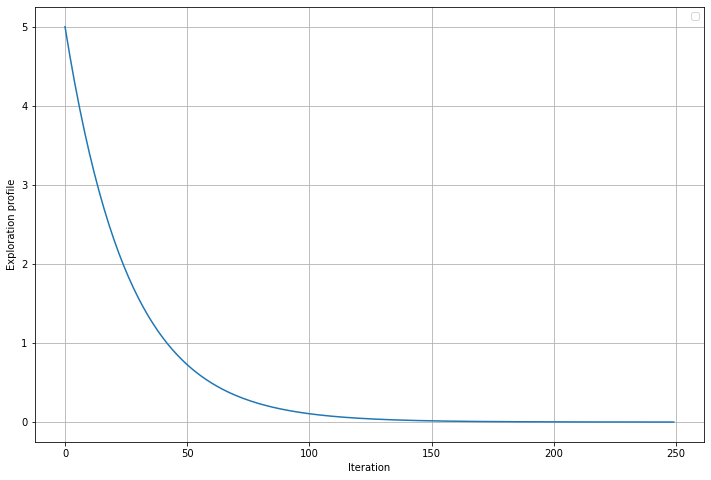

In [16]:
### Define exploration profile
initial_value = 5
num_iterations = 250
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exp_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exp exploration profile
plt.figure(figsize=(12,8))

plt.plot(exp_profile)
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile')

## Gym Environment (CartPole-v1)

In [17]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Network update

### Initialization

In [18]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 30000   # Replay memory capacity
lr = 1e-4   # Optimizer learning rate
target_net_update_steps = 1   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [19]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)  
short_mem = ShortMemory(3)

### Initialize the policy network
policy_net = DQN(3, 2)
policy_net.to(device)
### Initialize the target network with the same weights of the policy network
target_net = DQN(3, 2)
target_net.to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

### Update function

In [20]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states = []
    for i in range(len(batch)):
      states.append(batch[i][0])
    states = torch.stack(states)
    states = states.squeeze()
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = []
    non_final_mask = []
    for i in range(len(batch)):
        if batch[i][2] is None:
          non_final_mask.append(False)
        else:
          non_final_next_states.append(batch[i][2])
          non_final_mask.append(True)
    non_final_next_states = torch.stack(non_final_next_states).to(device)
    non_final_mask = torch.tensor(non_final_mask,dtype=torch.bool)


    # Compute all the Q values (forward pass)
    policy_net.train()
    states = states.to(device)
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.cpu().gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards.cpu() + (next_state_max_q_values.cpu() * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

### Training loop

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Updating target network...
EPISODE: 1 - FINAL SCORE: 22 - Epsilon: 0.5
Updating target network...
EPISODE: 2 - FINAL SCORE: 11 - Epsilon: 0.48105499030220605
Updating target network...
EPISODE: 3 - FINAL SCORE: 9 - Epsilon: 0.4628278073893112
Updating target network...
EPISODE: 4 - FINAL SCORE: 20 - Epsilon: 0.4452912527905129
Updating target network...
EPISODE: 5 - FINAL SCORE: 8 - Epsilon: 0.42841915858559476
Updating target network...
EPISODE: 6 - FINAL SCORE: 21 - Epsilon: 0.4121863483573452
Updating target network...
EPISODE: 7 - FINAL SCORE: 60 - Epsilon: 0.39656859962348884
Updating target network...
EPISODE: 8 - FINAL SCORE: 35 - Epsilon: 0.38154260769207377
Updating target network...
EPISODE: 9 - FINAL SCORE: 11 - Epsilon: 0.36708595088637797
Updating target network...
EPISODE: 10 - FINAL SCORE: 13 - Epsilon: 0.3531770570874453
Updating target network...
EPISODE: 11 - FINAL SCORE: 16 - Epsilon: 0.3397951715443254
Updating target network...
EPISODE: 12 - FINAL SCORE: 20 - Epsil

Text(0, 0.5, 'Scores')

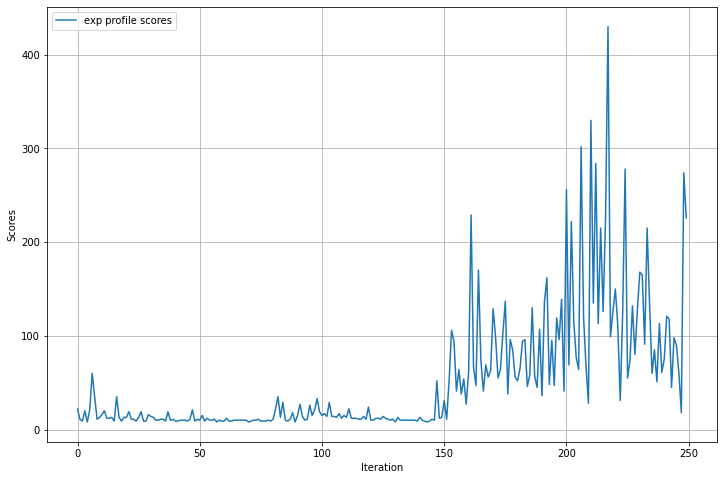

In [21]:
# Initialize the Gym environment
import math
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
scores_l = []
for episode_num, tau in enumerate(tqdm(exp_profile)):

    # Reset the environment and get the initial state
    #state = env.reset()
    num_states = env.reset()
    short_mem = ShortMemory(3)
    fig = env.render(mode='rgb_array')
    state = resize(fig)
    center = num_states[0]*25+120
    state = T.functional.crop(state,top=60,left=int(center-40),height=80,width=80)
    short_mem.push(state)
    last4_states = short_mem.get()
    last4_states = last4_states.unsqueeze(0)

    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:
      # Choose the action following the policy
      action, q_values = choose_action_epsilon_greedy(policy_net, last4_states, epsilon = tau/10)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down
        #if episode_num < 30: 
        #  reward = reward/3
        next_state = None
      
      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(num_states[0]) 
      num_states = next_state
      if next_state is not None:
        fig = env.render(mode='rgb_array')
        next_state = resize(fig)
        center = num_states[0]*25+120
        next_state = T.functional.crop(next_state,top=60,left=int(center-40),height=80,width=80)
        short_mem.push(next_state)
        next4_states = short_mem.get()
        replay_mem.push(last4_states, action, next4_states, reward)
        next4_states = next4_states.unsqueeze(0)
      else:
        replay_mem.push(last4_states, action, next_state, reward)
      

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
          

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      last4_states = next4_states

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    scores_l.append(score)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Epsilon: {tau/10}") # Print the final score

env.close()
### Plot exp exploration profile
plt.figure(figsize=(12,8))
plt.plot(scores_l, label='exp profile scores')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

In [22]:
# Display the videos, not required outside Colab
show_videos()

## Final test

In [23]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    num_states = env.reset()
    short_mem = ShortMemory(3)
    fig = env.render(mode='rgb_array')
    state = resize(fig)
    center = num_states[0]*25+120
    state = T.functional.crop(state,top=60,left=int(center-40),height=80,width=80)
    short_mem.push(state)
    last4_states = short_mem.get()
    last4_states = last4_states.unsqueeze(0)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_epsilon_greedy(policy_net, last4_states, epsilon = 0)
      #print(action)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      fig = env.render(mode='rgb_array')
      num_states = next_state
      next_state = resize(fig)
      center = num_states[0]*25+120
      next_state = T.functional.crop(next_state,top=60,left=int(center-40),height=80,width=80)
      short_mem.push(next_state)
      next4_states = short_mem.get()
      next4_states = next4_states.unsqueeze(0)
      #next_state = next_state.unsqueeze(0)
      # Set the current state for the next iteration
      last4_states = next4_states
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


EPISODE 1 - FINAL SCORE: 23.0
EPISODE 2 - FINAL SCORE: 59.0
EPISODE 3 - FINAL SCORE: 46.0
EPISODE 4 - FINAL SCORE: 88.0
EPISODE 5 - FINAL SCORE: 55.0
EPISODE 6 - FINAL SCORE: 44.0
EPISODE 7 - FINAL SCORE: 37.0
EPISODE 8 - FINAL SCORE: 46.0
EPISODE 9 - FINAL SCORE: 111.0
EPISODE 10 - FINAL SCORE: 49.0


In [24]:
# Display the videos, not required outside Colab
show_videos()

In [25]:
torch.save(policy_net.state_dict(), 'policy_params.pth')
torch.save(target_net.state_dict(), 'target_params.pth')